In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Data Visualization & Engineering

In [21]:
# Sample dataset of REB resources
reb_resources = pd.DataFrame({
    'Grade Level': ['Primary 1', 'Primary 2', 'Primary 3'],
    'Subject': ['Math', 'Science', 'English'],
    'Topic Keywords': ['Addition, Subtraction, multiplicatin division', 'Plants, Animals, water, air', 'Grammar, Vocabulary'],
    'URL': [
        'https://elearning.reb.rw/pluginfile.php/45472/mod_resource/content/2/MATH%20P1.pdf',
        'https://elearning.reb.rw/pluginfile.php/85767/mod_resource/content/1/SET%20P2%20Student%20Book.pdf',
        'https://elearning.reb.rw/pluginfile.php/45481/mod_resource/content/1/English%20p3.pdf'
    ]
})

reb_resources.head()

,Grade Level,Subject,Topic Keywords,URL
0,Primary 1,Math,"Addition, Subtraction, multiplicatin division",https://elearning.reb.rw/pluginfile.php/45472/...
1,Primary 2,Science,"Plants, Animals, water, air",https://elearning.reb.rw/pluginfile.php/85767/...
2,Primary 3,English,"Grammar, Vocabulary",https://elearning.reb.rw/pluginfile.php/45481/...


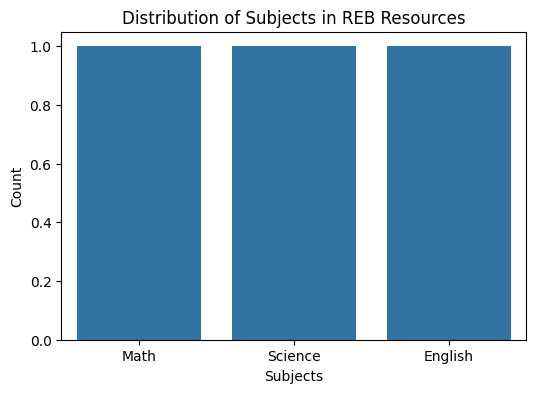

In [22]:
# Visualizing the distribution of subjects
plt.figure(figsize=(6,4))
sns.countplot(x='Subject', data=reb_resources)
plt.title("Distribution of Subjects in REB Resources")
plt.xlabel("Subjects")
plt.ylabel("Count")
plt.show()

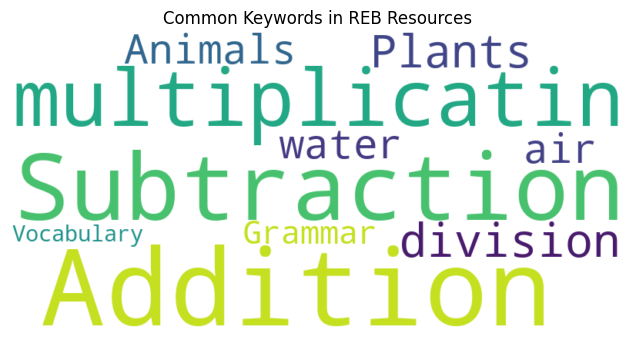

In [23]:
# Creating a word cloud of topic keywords
all_keywords = ' '.join(reb_resources['Topic Keywords'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

plt.figure(figsize=(8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Keywords in REB Resources")
plt.show()

In [6]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [13]:
# Convert topic keywords into a single text column
reb_resources['Combined Text'] = reb_resources[['Grade Level', 'Subject', 'Topic Keywords']].agg(' '.join, axis=1)

In [14]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
resource_vectors = vectorizer.fit_transform(reb_resources['Combined Text'])

In [17]:
def get_recommendation(assignment_desc):
    """Recommend REB e-learning resource based on assignment description."""
    # Preprocess assignment text
    assignment_doc = nlp(assignment_desc.lower())
    keywords = ' '.join([token.lemma_ for token in assignment_doc if not token.is_stop])
    
    # Convert to TF-IDF vector
    assignment_vector = vectorizer.transform([keywords])
    
    # Compute similarity
    similarities = cosine_similarity(assignment_vector, resource_vectors)
    
    # Get the best match
    best_match_idx = np.argmax(similarities)
    best_resource = reb_resources.iloc[best_match_idx]
    
    return best_resource['URL']

In [18]:
# Example Usage
assignment_text = "Practice basic addition and subtraction."
recommended_url = get_recommendation(assignment_text)
print("Recommended REB Resource:", recommended_url)


Recommended REB Resource: https://elearning.reb.rw/pluginfile.php/45472/mod_resource/content/2/MATH%20P1.pdf
